## Software Comparison 2 with NIDM-Results

This notebook demonstates how to reproduce the results presented in the second Software Comparison publication using NIDM-Results packs available at [NeuroVault (7222)](http://neurovault.org/collections/7222/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler characteristics, Bland-Altman plots and Dice coefficients.


In [23]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 7222
 - Download and save the packs in sub-folder `input/ds001/` 

In [51]:
from lib import download_data
reload(download_data)
download_data.download_data('7222', 'ds001', 'ds001')

downloading https://neurovault.org/collections/7222/group.gfeat.nidm.zip at ./input/ds001/group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7222/spm_0001.nidm.zip at ./input/ds001/spm_0001.nidm.zip
downloading https://neurovault.org/collections/7222/spm_0002.nidm.zip at ./input/ds001/spm_0002.nidm.zip
downloading http://neurovault.org/media/images/7222/mask.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/afni_mask.nii.gz
downloading http://neurovault.org/media/images/7222/Negative_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/afni_exc_set_neg.nii.gz
downloading http://neurovault.org/media/images/7222/Positive_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/afni_exc_set_pos.nii.gz
downloading http://neurovault.org/media/images/7222/3dMEMA_result_t_stat_masked.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/afni_stat.nii.gz
downloading http://neurovault.org/media/images/7222/perm_ttest++_Clustsim_result

In [52]:
study = 'ds001'
num_subjects = 15

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Euler Characteristics and Cluster Count
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_cluster_count = pd.read_csv('./input/' + study + '/afni_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_cluster_count = pd.read_csv('./input/' + study + '/fsl_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_cluster_count = pd.read_csv('./input/' + study + '/spm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars, afni_cluster_count, fsl_cluster_count, spm_cluster_count], axis=1)

# *** Permutation Test images
afni_perm = './input/' + study + '/afni_perm.nii.gz'
afni_perm_z = './input/' + study + '/afni_perm_z.nii.gz'
afni_perm_pos_exc = './input/' + study + '/afni_perm_exc_set_pos.nii.gz'
afni_perm_neg_exc = './input/' + study + '/afni_perm_exc_set_neg.nii.gz'
afni_perm_mask = './input/' + study + '/afni_mask_perm.nii.gz'
fsl_perm = './input/' + study + '/fsl_perm.nii.gz'
fsl_perm_pos_exc = './input/' + study + '/fsl_perm_exc_set_pos.nii.gz'
fsl_perm_neg_exc = './input/' + study + '/fsl_perm_exc_set_neg.nii.gz'
spm_perm = './input/' + study + '/spm_perm.nii.gz'
spm_perm_pos_exc = './input/' + study + '/spm_perm_exc_set_pos.nii.gz'
spm_perm_neg_exc = './input/' + study + '/spm_perm_exc_set_neg.nii.gz'

perm_exc_sets = dict()
perm_exc_sets["spm permutation"] = (spm_mask_file, (spm_perm_pos_exc, spm_perm_neg_exc), spm_perm)
perm_exc_sets["fsl permutation"] = (fsl_mask_file, (fsl_perm_pos_exc, fsl_perm_neg_exc), fsl_perm)
perm_exc_sets["afni permutation"] = (afni_perm_mask, (afni_perm_pos_exc, afni_perm_neg_exc), afni_perm)

# *** Permutation Test Euler Characteristics and Cluster Count
afni_perm_euler_chars = pd.read_csv('./input/' + study + '/afni_perm_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_perm_euler_chars = pd.read_csv('./input/' + study + '/fsl_perm_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_perm_euler_chars = pd.read_csv('./input/' + study + '/spm_perm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_perm_cluster_count = pd.read_csv('./input/' + study + '/afni_perm_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_perm_cluster_count = pd.read_csv('./input/' + study + '/fsl_perm_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_perm_cluster_count = pd.read_csv('./input/' + study + '/spm_perm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
perm_euler_chars = pd.concat([afni_perm_euler_chars, fsl_perm_euler_chars, spm_perm_euler_chars, afni_perm_cluster_count, fsl_perm_cluster_count, spm_perm_cluster_count], axis=1)

# *** BOLD images
#afni_bold = './input/' + study + '/afni_bold.nii.gz'
#fsl_bold = './input/' + study + '/fsl_bold.nii.gz'
#spm_bold = './input/' + study + '/spm_bold.nii.gz'

- Downloading this study's results from the 'Exploring the impact of analysis software on task fMRI results' manuscript 
- Query NeuroVault's API to retreive all NIDM packs in collection 4110
- Download and save the packs in sub-folder `input/ds001/` 

In [54]:
from lib import download_old_data
reload(download_old_data)
download_old_data.download_old_data('4110', 'ds001', 'ds001')

downloading https://neurovault.org/collections/4110/group.gfeat.nidm.zip at ./input/ds001/old_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/4110/spm_0001.nidm.zip at ./input/ds001/old_spm_0001.nidm.zip
downloading https://neurovault.org/collections/4110/spm_0002.nidm.zip at ./input/ds001/old_spm_0002.nidm.zip
downloading http://neurovault.org/media/images/4110/mask.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/old_afni_mask.nii.gz
downloading http://neurovault.org/media/images/4110/Negative_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/old_afni_exc_set_neg.nii.gz
downloading http://neurovault.org/media/images/4110/Positive_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/old_afni_exc_set_pos.nii.gz
downloading http://neurovault.org/media/images/4110/3dMEMA_result_t_stat_masked.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds001/old_afni_stat.nii.gz
downloading http://neurovault.org/media/images/4110/

In [55]:
# *** SPM group activations
spm_pack = open('./input/' + study + '/old_spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_spm_exc_set_file = './input/' + study + '/old_spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', old_spm_exc_set_file)

# Unthresholded statistics
old_spm_stat_file = './input/' + study + '/old_spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', old_spm_stat_file)

# Analysis mask
old_spm_mask_file = './input/' + study + '/old_spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', old_spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/old_spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_spm_exc_set_file_neg = './input/' + study + '/old_spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', old_spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/old_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_fsl_exc_set_file = './input/' + study + '/old_fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', old_fsl_exc_set_file)
old_fsl_exc_set_file_neg = './input/' + study + '/old_fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', old_fsl_exc_set_file_neg)

# Unthresholded statistics
old_fsl_stat_file = './input/' + study + '/old_fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', old_fsl_stat_file)

# Analysis mask
old_fsl_mask_file = './input/' + study + '/old_fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', old_fsl_mask_file)

# *** AFNI group activations and deactivations
old_afni_mask_file = './input/' + study + '/old_afni_mask.nii.gz'
old_afni_exc_set_file = './input/' + study + '/old_afni_exc_set_pos.nii.gz'
old_afni_exc_set_file_neg = './input/' + study + '/old_afni_exc_set_neg.nii.gz'
old_afni_stat_file = './input/' + study + '/old_afni_stat.nii.gz'

old_exc_sets = dict()
old_exc_sets["spm"] = (old_spm_mask_file, (old_spm_exc_set_file, old_spm_exc_set_file_neg), old_spm_stat_file)
old_exc_sets["fsl"] = (old_fsl_mask_file, (old_fsl_exc_set_file, old_fsl_exc_set_file_neg), old_fsl_stat_file)
old_exc_sets["afni"] = (old_afni_mask_file, (old_afni_exc_set_file, old_afni_exc_set_file_neg), old_afni_stat_file)

# *** Permutation Test images
old_afni_perm_z = './input/' + study + '/old_afni_perm_z.nii.gz'
old_afni_perm_pos_exc = './input/' + study + '/old_afni_perm_exc_set_pos.nii.gz'
old_afni_perm_neg_exc = './input/' + study + '/old_afni_perm_exc_set_neg.nii.gz'
old_afni_perm_mask = './input/' + study + '/old_afni_mask_perm.nii.gz'
old_fsl_perm = './input/' + study + '/old_fsl_perm.nii.gz'
old_fsl_perm_pos_exc = './input/' + study + '/old_fsl_perm_exc_set_pos.nii.gz'
old_fsl_perm_neg_exc = './input/' + study + '/old_fsl_perm_exc_set_neg.nii.gz'
old_spm_perm = './input/' + study + '/old_spm_perm.nii.gz'
old_spm_perm_pos_exc = './input/' + study + '/old_spm_perm_exc_set_pos.nii.gz'
old_spm_perm_neg_exc = './input/' + study + '/old_spm_perm_exc_set_neg.nii.gz'

old_perm_exc_sets = dict()
old_perm_exc_sets["spm permutation"] = (old_spm_mask_file, (old_spm_perm_pos_exc, old_spm_perm_neg_exc), old_spm_perm)
old_perm_exc_sets["fsl permutation"] = (old_fsl_mask_file, (old_fsl_perm_pos_exc, old_fsl_perm_neg_exc), old_fsl_perm)
old_perm_exc_sets["afni permutation"] = (old_afni_perm_mask, (old_afni_perm_pos_exc, old_afni_perm_neg_exc), old_afni_perm_z)

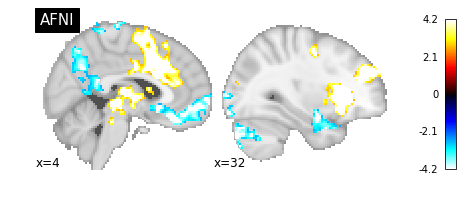

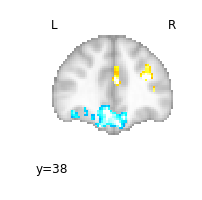

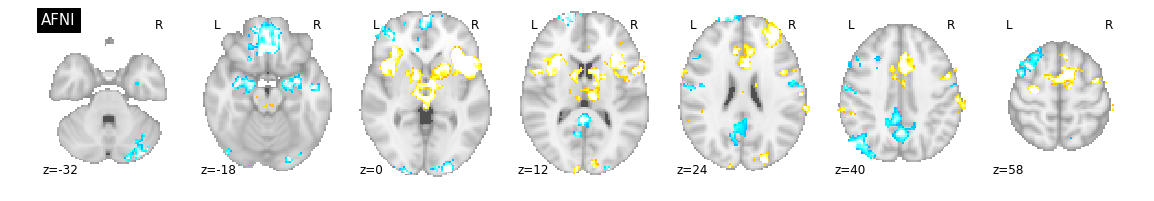

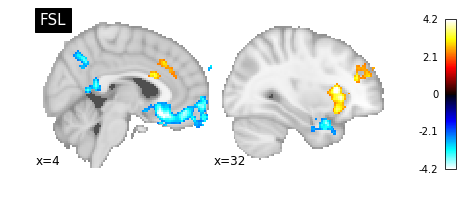

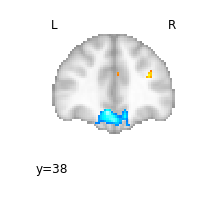

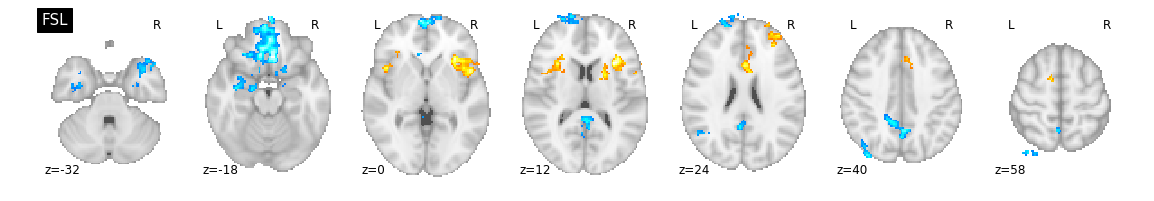

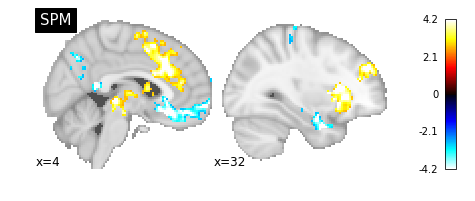

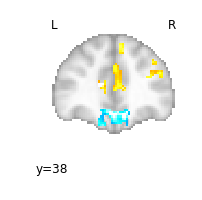

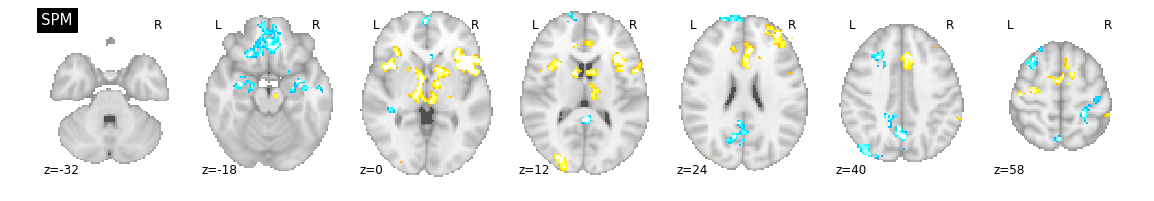

In [31]:
from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=4.2
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[4, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

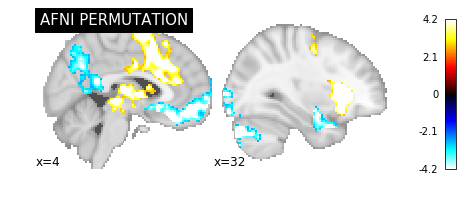

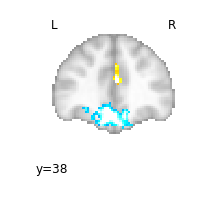

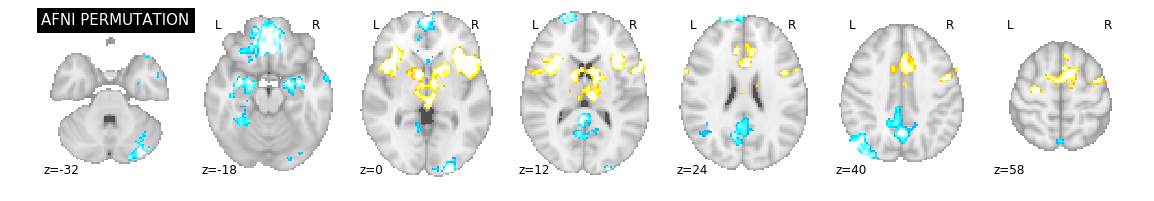

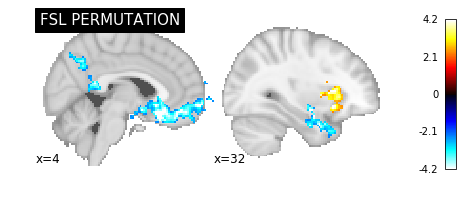

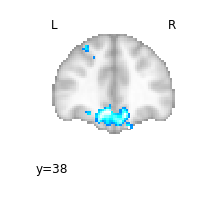

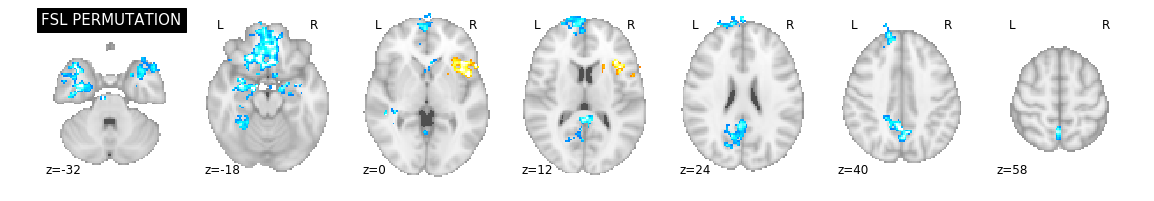

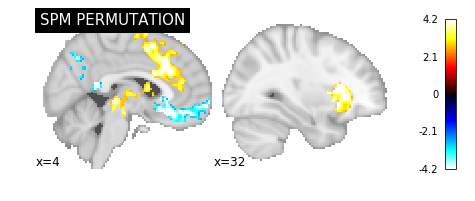

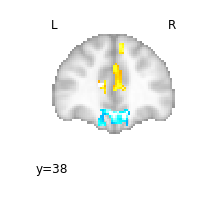

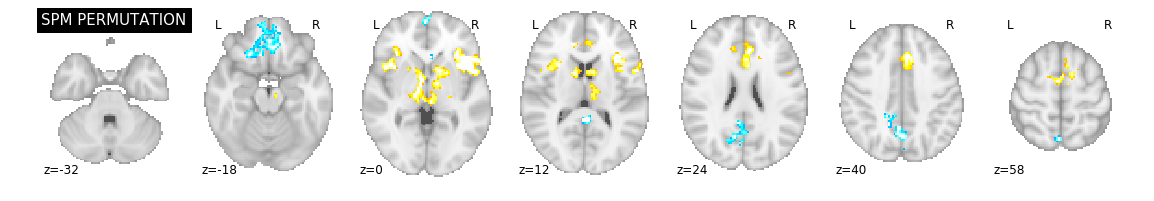

In [32]:
# Plot t-statistic images for permutation test inference results in each software
plot_excursion_sets.plot_excursion_sets(perm_exc_sets, max_activation, x_coords, y_coords, z_coords)

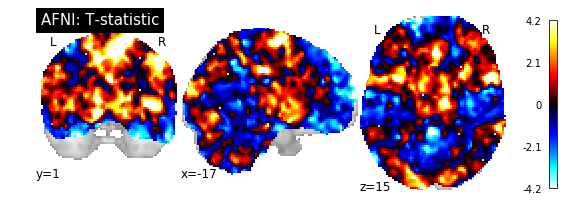

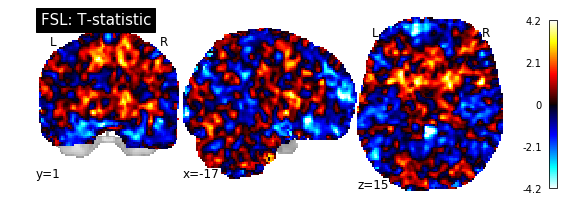

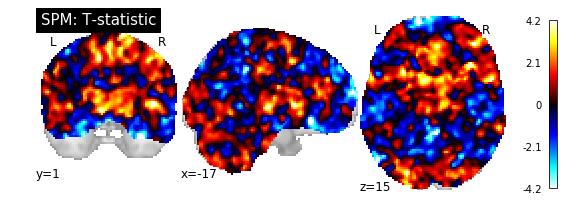

In [33]:
from lib import plot_stat_images
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_file)

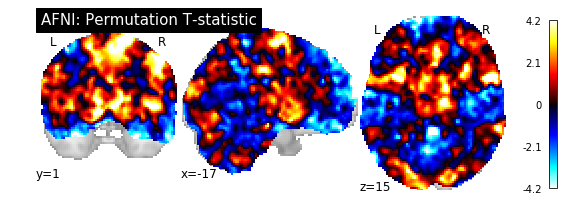

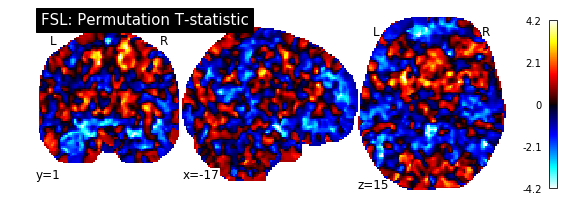

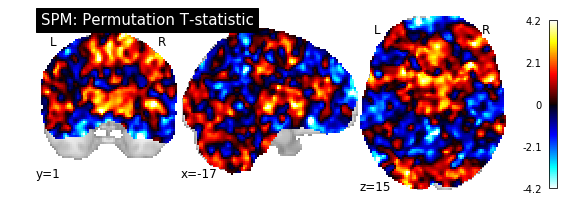

In [34]:
plot_stat_images.plot_stat_images(afni_perm, spm_perm, max_activation, [-17, 1, 15], 'Permutation T-statistic', fsl_perm)

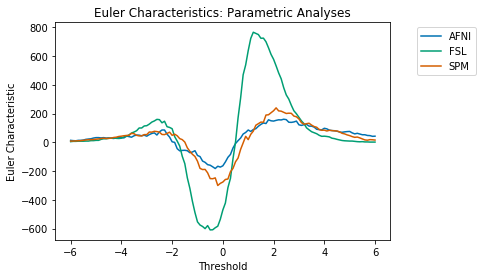

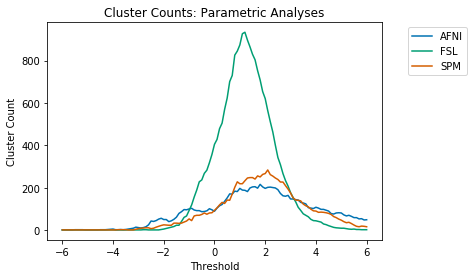

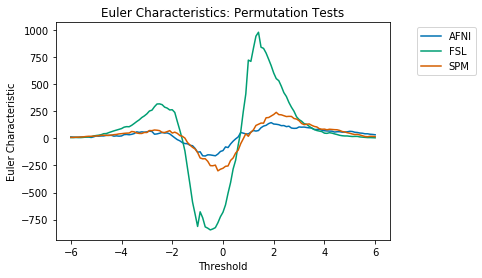

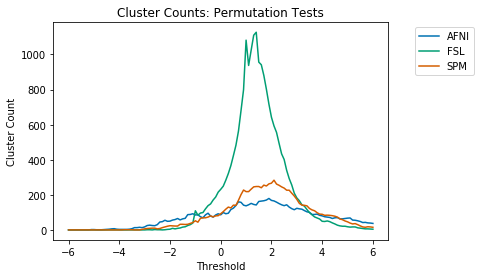

In [35]:
from lib import euler_characteristics
euler_characteristics.euler_characteristics(euler_chars, 'Parametric Analyses')
euler_characteristics.euler_characteristics(perm_euler_chars, 'Permutation Tests')

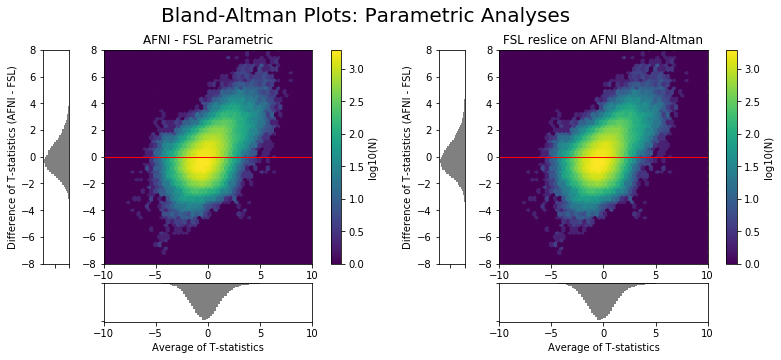

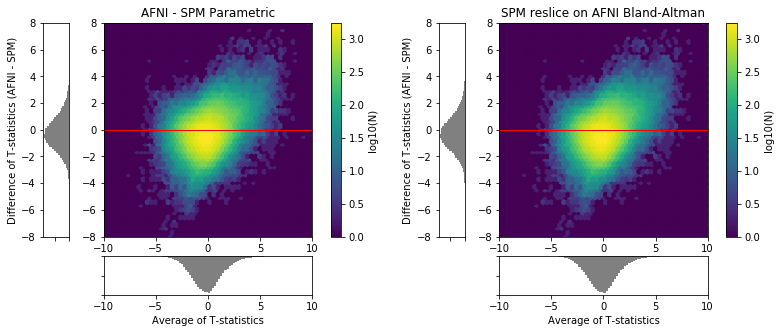

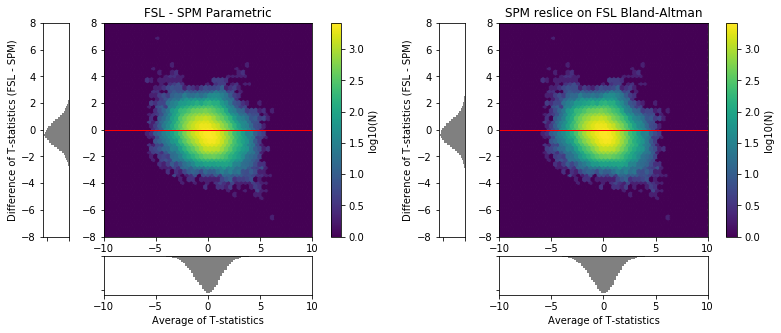

In [36]:
from lib import bland_altman
bland_altman.bland_altman('Bland-Altman Plots: Parametric Analyses', afni_stat_file, spm_stat_file,
            'AFNI - SPM Parametric', 'AFNI - FSL Parametric', 'FSL - SPM Parametric',
             fsl_stat_file, study=study)

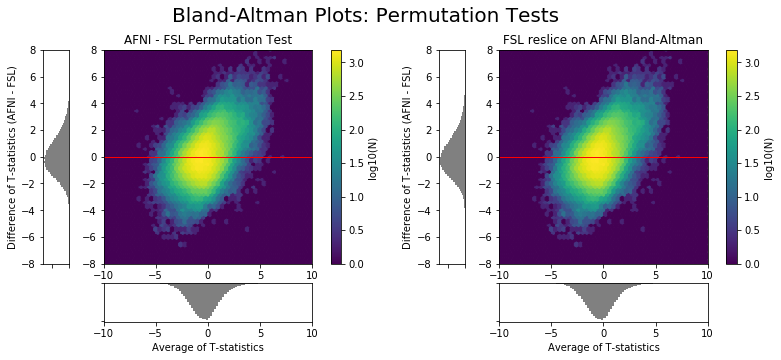

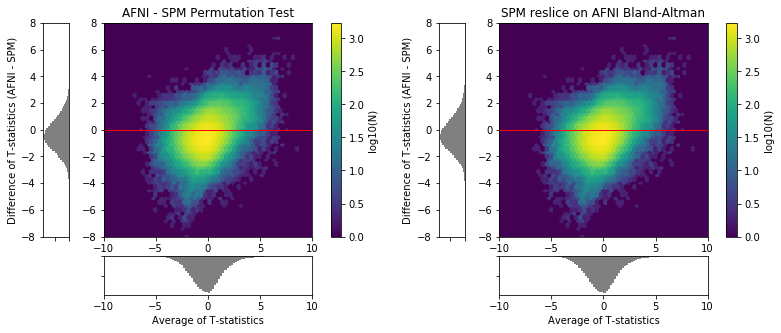

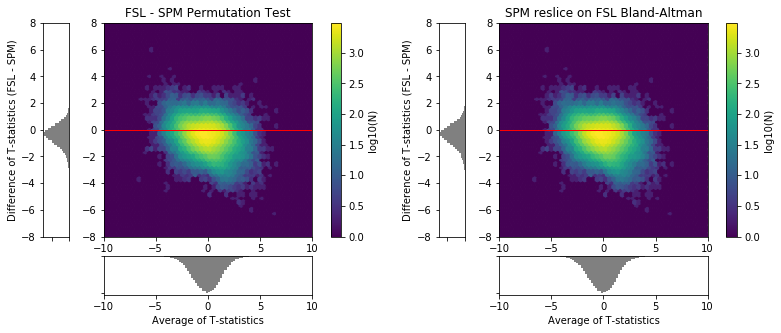

In [37]:
bland_altman.bland_altman('Bland-Altman Plots: Permutation Tests', afni_perm_z, spm_perm,
            'AFNI - SPM Permutation Test', 'AFNI - FSL Permutation Test', 'FSL - SPM Permutation Test',
             fsl_perm, num_subjects=num_subjects, study=study + '_perm')

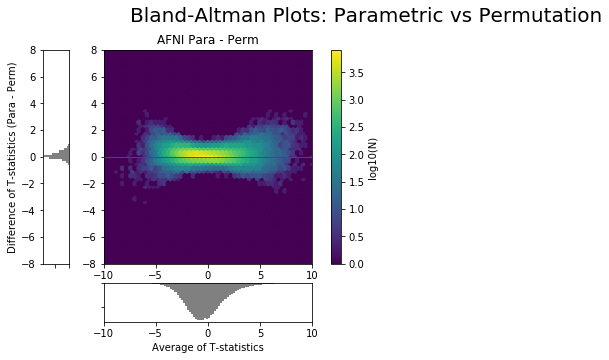

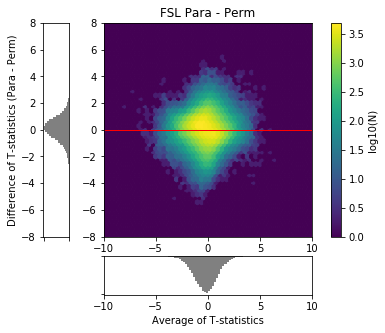

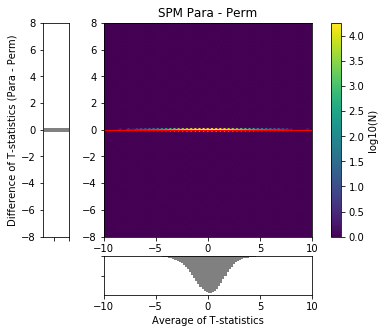

In [38]:
bland_altman.bland_altman_intra('Bland-Altman Plots: Parametric vs Permutation', afni_stat_file, afni_perm_z,
             fsl_stat_file, fsl_perm,
             spm_stat_file, spm_perm, num_subjects=num_subjects, 
             study=study + '_permintra')

AFNI/FSL positive activation dice coefficient = 0.266768, 0, 0
AFNI/SPM positive activation dice coefficient = 0.523301, 0, 0
FSL/SPM positive activation dice coefficient = 0.401836, 0, 0
Permutation test AFNI/SPM positive activation dice coefficient = 0.578777, 0, 0
Permutation test AFNI/FSL positive activation dice coefficient = 0.169321, 0, 0
Permutation test FSL/SPM positive activation dice coefficient = 0.291089, 0, 0
AFNI classical inference/permutation test positive activation dice coefficient = 0.822989, 0, 0
FSL classical inference/permutation test positive activation dice coefficient = 0.489037, 0, 0
SPM classical inference/permutation test positive activation dice coefficient = 0.909854, 0, 0
AFNI parametric/FSL permutation positive activation dice coefficient = 0.138575, 0, 0
AFNI parametric/SPM permutation positive activation dice coefficient = 0.498322, 0, 0
FSL parametric/AFNI permutation positive activation dice coefficient = 0.284429, 0, 0
FSL parametric/SPM permutatio

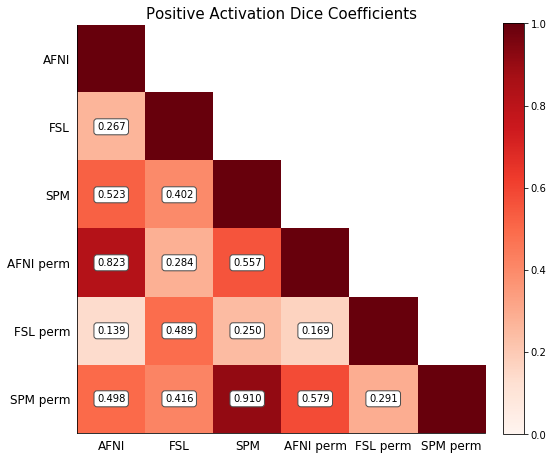

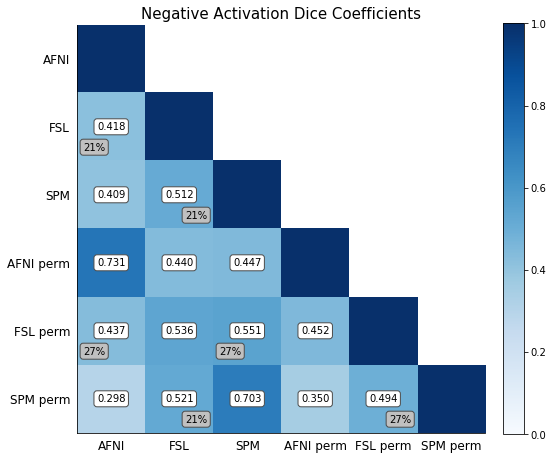

In [39]:
from lib import dice
dice.dice(afni_exc_set_file, spm_exc_set_file, 
         afni_perm_pos_exc, spm_perm_pos_exc,
         afni_exc_set_file_neg, spm_exc_set_file_neg,
         fsl_exc_set_file, fsl_exc_set_file_neg, 
         fsl_perm_pos_exc,
         afni_perm_neg_exc, fsl_perm_neg_exc, spm_perm_neg_exc, study=study,
         afni_stat_file=afni_stat_file, fsl_stat_file=fsl_stat_file, spm_stat_file=spm_stat_file,
         afni_perm=afni_perm, fsl_perm=fsl_perm, spm_perm=spm_perm,)

pixdim[1,2,3] should be positive; setting to abs of pixdim values
pixdim[1,2,3] should be positive; setting to abs of pixdim values


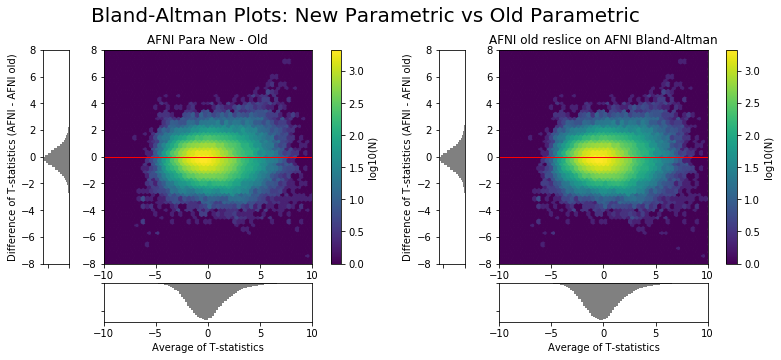

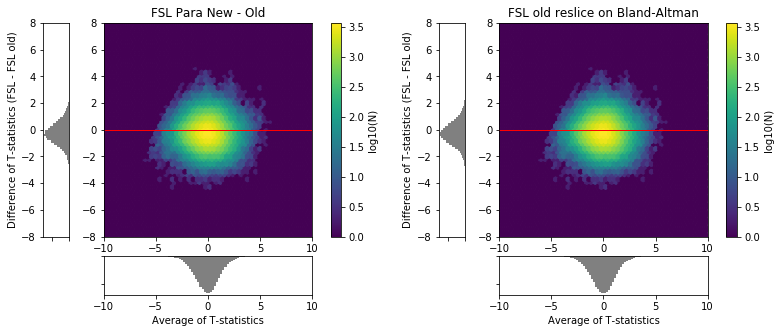

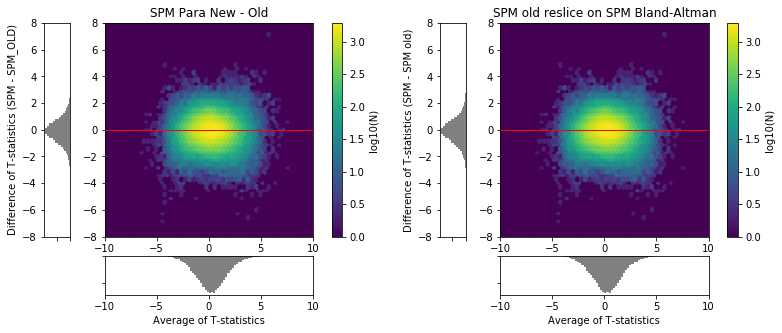

In [42]:
reload(bland_altman)
bland_altman.bland_altman_old_comparison("Bland-Altman Plots: New Parametric vs Old Parametric", afni_stat_file, spm_stat_file,
                            old_afni_stat_file, old_spm_stat_file, "AFNI Para New - Old", "FSL Para New - Old",
                            "SPM Para New - Old", fsl_stat_file, old_fsl_stat_file, study=study)

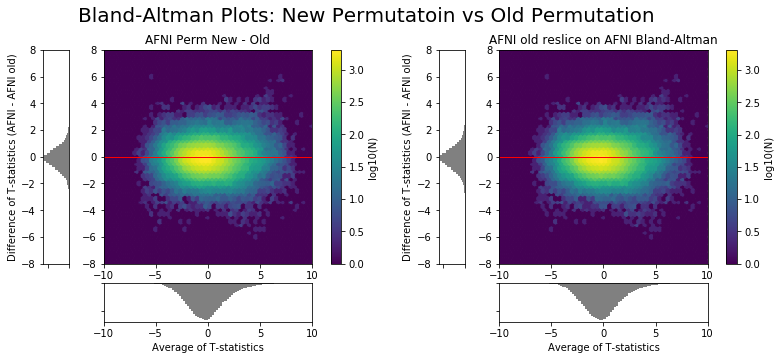

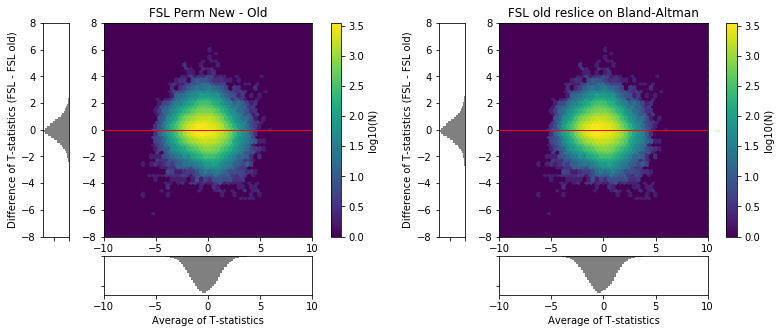

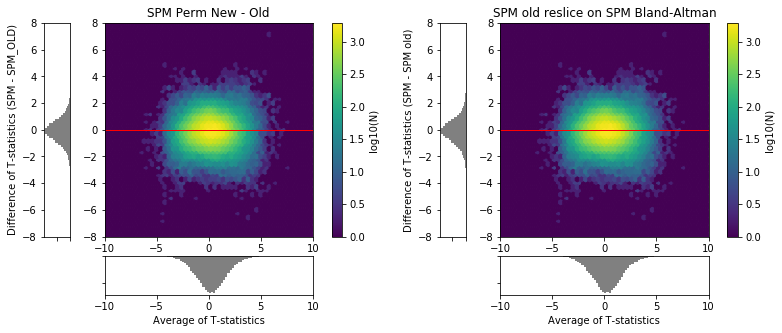

In [43]:
bland_altman.bland_altman_old_comparison("Bland-Altman Plots: New Permutatoin vs Old Permutation", afni_perm_z, spm_perm,
                            old_afni_perm_z, old_spm_perm, "AFNI Perm New - Old", "FSL Perm New - Old",
                            "SPM Perm New - Old", fsl_perm, old_fsl_perm, num_subjects=num_subjects, study=study + '_perm')

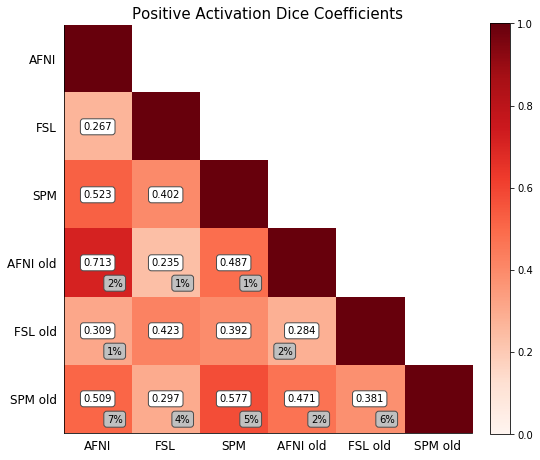

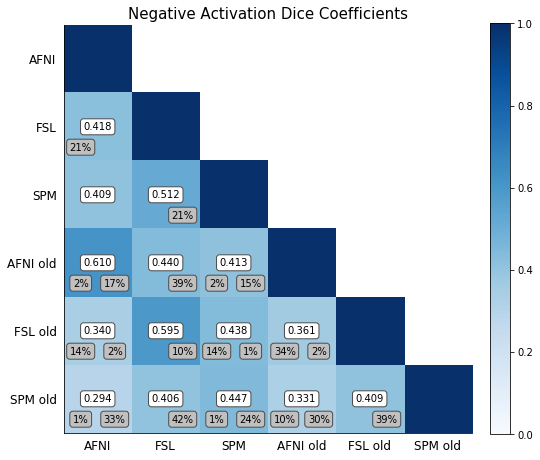

In [69]:
reload(dice)
dice.dice_old_comparison(afni_exc_set_file, old_afni_exc_set_file, afni_exc_set_file_neg, old_afni_exc_set_file_neg,
                        fsl_exc_set_file, old_fsl_exc_set_file, fsl_exc_set_file_neg, old_fsl_exc_set_file_neg, 
                        spm_exc_set_file, old_spm_exc_set_file, spm_exc_set_file_neg, old_spm_exc_set_file_neg, 
                        afni_stat_file, old_afni_stat_file, fsl_stat_file, old_fsl_stat_file, spm_stat_file, 
                        old_spm_stat_file, study=study)

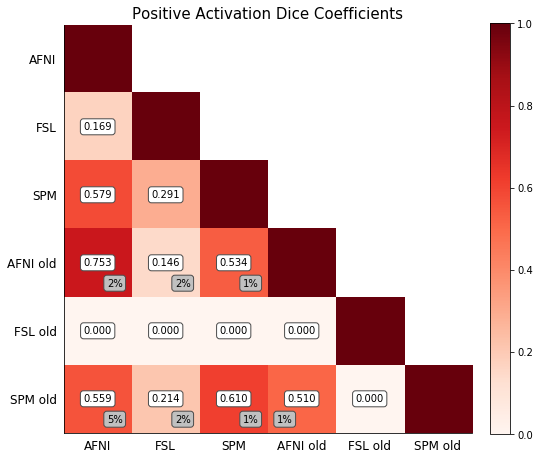

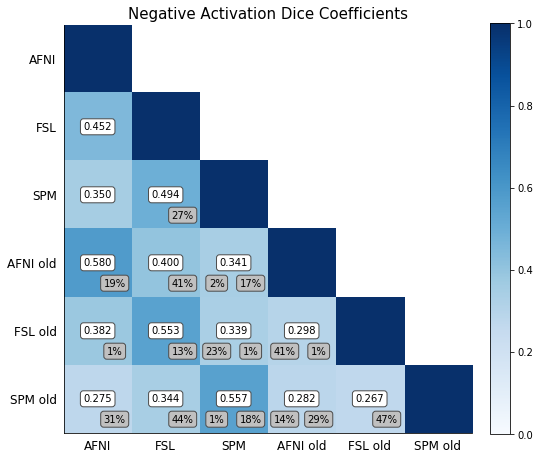

In [72]:
dice.dice_old_comparison(afni_perm_pos_exc, old_afni_perm_pos_exc, afni_perm_neg_exc, old_afni_perm_neg_exc, 
                         fsl_perm_pos_exc,  old_fsl_perm_pos_exc, fsl_perm_neg_exc, old_fsl_perm_neg_exc, 
                         spm_perm_pos_exc,  old_spm_perm_pos_exc, spm_perm_neg_exc, old_spm_perm_neg_exc,
                         afni_perm, old_afni_perm_z, fsl_perm, old_fsl_perm, spm_perm, old_spm_perm, study=study + '_perm')